<a href="https://colab.research.google.com/github/salty-vanilla/keras-gans/blob/master/gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import keras
from keras import Sequential, Model
from keras.layers import Dense, Conv2D, Conv2DTranspose, BatchNormalization, Reshape, Flatten, Input, Dropout, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras.datasets import mnist, fashion_mnist
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

Using TensorFlow backend.


In [0]:
image_shape = (28, 28, 1)

## ハイパーパラメータの設定
* GANはハイパーパラメータ調整に非常に敏感です
* 学習係数を変更することで，大きく学習結果が変わります


In [0]:
latent_dim = 100
epochs = 10
batch_size = 100
lr_g = 2e-3
lr_d = 2e-3
beta_1 = 0.5
beta_2 = 0.99

## Generatorの構築
* 今回はMNISTを学習するため，目標サイズは(28, 28, 1)
* `latent_dim` 次元のベクトルに全結合 ＋ 3回のUpsampling
* 最後の活性化関数を`tanh`にするのが慣習

In [0]:
generator = Sequential([
    Dense(3*3*256, input_dim=latent_dim),
    Reshape((3, 3, 256)),
    BatchNormalization(),
    Activation('relu'),

    
    Conv2DTranspose(128, 5, strides=1, padding='valid',
                    kernel_initializer='glorot_normal'),
    BatchNormalization(),
    Activation('relu'),
    
    Conv2DTranspose(64, 5, strides=2, padding='same',
                    kernel_initializer='glorot_normal'),
    BatchNormalization(),
    Activation('relu'),
    
    Conv2DTranspose(1, 5, strides=2, padding='same',
                    kernel_initializer='glorot_normal'),
    Activation('tanh')
])
generator.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2304)              232704    
_________________________________________________________________
reshape_1 (Reshape)          (None, 3, 3, 256)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3, 3, 256)         1024      
_________________________________________________________________
activation_1 (Activation)    (None, 3, 3, 256)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 7, 7, 128)         819328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
acti

## Discriminatorの構築
* (28, 28, 1)から1次元のベクトルを出力
* 出力が[0, 1]になるようにsigmoidをかける

In [0]:
discriminator = Sequential([
    Conv2D(32, 3, padding='same', strides=2,
           input_shape=image_shape),
    LeakyReLU(0.2),
    
    Conv2D(64, 3, padding='same', strides=2),
    LeakyReLU(0.2),

    Conv2D(128, 3, padding='same', strides=2),
    LeakyReLU(0.2),

    Conv2D(256, 3, padding='same', strides=2),
    LeakyReLU(0.2),

    Flatten(),
    Dense(1, activation='sigmoid')
])
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 2, 256)         295168    
__________

## Discriminatorのビルド
* Loss関数はBCE

In [0]:
discriminator.compile(
    optimizer=Adam(lr=lr_d, 
                   beta_1=beta_1,
                   beta_2=beta_2),
    loss='binary_crossentropy')

**ここで，`trainable` を `False`にする**   
これにより，Generatorを更新する際にDiscriminatorのパラメータも一緒に更新されてしまうのを防ぐ

In [0]:
discriminator.trainable = False

## Generator  + Discriminator のビルド
* ただし，Discriminatorはfixされている
* Loss関数は同じくBCE

In [0]:
latent = Input(shape=(latent_dim, ))
combined = Sequential([generator, discriminator])
combined.compile(
    optimizer=Adam(lr=lr_g, 
                   beta_1=beta_1,
                   beta_2=beta_2),
    loss='binary_crossentropy')

## MNISTの準備
* Generatorの最後の活性化関数に合わせて，[-1, 1]に正規化

In [0]:
# MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Fashoin MNIST
# (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = (x_train.astype(np.float32) - 127.5) / 127.5
x_train = np.expand_dims(x_train, axis=-1)

x_test = (x_test.astype(np.float32) - 127.5) / 127.5
x_test = np.expand_dims(x_test, axis=-1)

nb_train, nb_test = x_train.shape[0], x_test.shape[0]

df = pd.DataFrame({'disc_loss': [],
                   'gen_loss': []})

In [0]:
# 1epoch に何回パラメータの更新があるか計算
steps_per_epoch = nb_train // batch_size
if nb_train % batch_size != 0:
    steps_per_epoch += 1

In [0]:
discriminator.trainable = True

## ここからFitループ


In [0]:
for epoch in range(1, epochs+1):
    print('Epoch %d/%d' % (epoch, epochs), end='\t')
    sum_disc_loss = 0
    sum_gen_loss = 0
    for iter_ in range(steps_per_epoch):
        # 画像バッチとノイズバッチの用意
        image_batch = x_train[iter_*batch_size: (iter_+1)*batch_size]
        noise = np.random.uniform(-1, 1, (len(image_batch), latent_dim))
        
        # fakeを生成
        generated_images = generator.predict(noise)
        
        # discriminator更新用にデータをconcat
        x = np.concatenate((image_batch, generated_images))
        y = np.array([1]*len(image_batch) + [0]*len(noise))

        # discriminatorの更新
        disc_loss = discriminator.train_on_batch(x, y)
        sum_disc_loss += disc_loss

        # generatorの更新
        y = [1]*len(noise)
        gen_loss = combined.train_on_batch(noise, y)
        sum_gen_loss += gen_loss
        
        df = df.append(pd.Series({'disc_loss': disc_loss,
                                  'gen_loss': gen_loss}),
                       ignore_index=True)
    
    print('disc_loss: %.4f  gen_loss: %.4f' % (sum_disc_loss/steps_per_epoch,
                                               sum_gen_loss/steps_per_epoch))
   
    # 生成画像を整形して保存
    vis_col = vis_row = int(np.sqrt(batch_size))
    h, w, _ = image_shape
    generated_images = generated_images[:vis_col*vis_row]
    generated_images = ((generated_images + 1) * 127.5).astype('uint8')
    generated_images = generated_images.reshape(vis_row, vis_col, h, w)
    generated_images = generated_images.transpose(0, 2, 1, 3)
    generated_images = generated_images.reshape(vis_row*h, vis_col*w)
    Image.fromarray(generated_images).save('epoch_%d.png' % epoch)


Epoch 1/10	WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


disc_loss: 0.3763  gen_loss: 3.0330
Epoch 2/10	disc_loss: 0.4062  gen_loss: 2.0630
Epoch 3/10	disc_loss: 0.4611  gen_loss: 1.8217
Epoch 4/10	disc_loss: 0.5200  gen_loss: 1.4907
Epoch 5/10	disc_loss: 0.5260  gen_loss: 1.4517
Epoch 6/10	disc_loss: 0.5228  gen_loss: 1.4472
Epoch 7/10	disc_loss: 0.5105  gen_loss: 1.5007
Epoch 8/10	disc_loss: 0.4824  gen_loss: 1.6390
Epoch 9/10	disc_loss: 0.4828  gen_loss: 1.6175
Epoch 10/10	disc_loss: 0.4782  gen_loss: 1.6503


## 生成した画像を見てみる

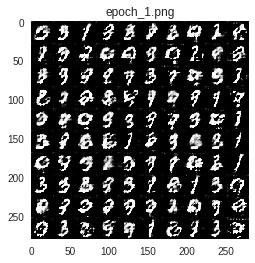

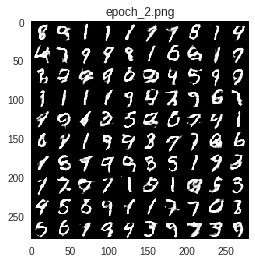

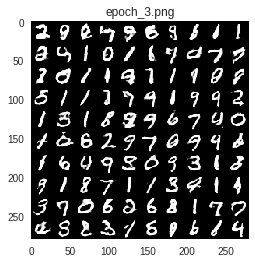

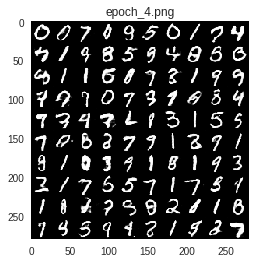

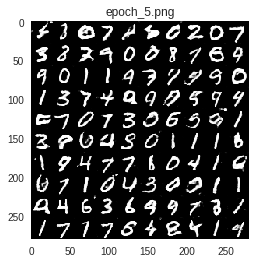

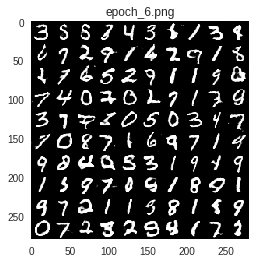

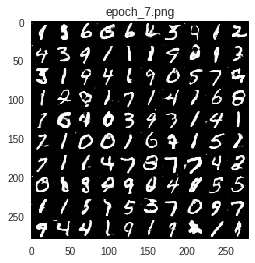

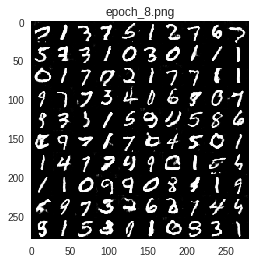

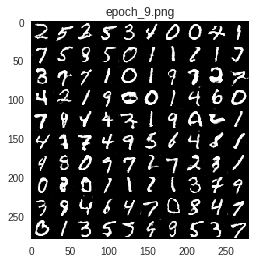

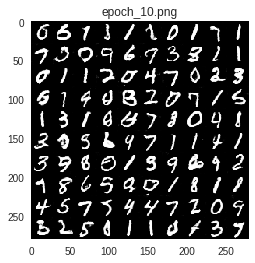

In [0]:
for e in range(1, epochs+1):
    plt.figure()
    im = Image.open('epoch_%d.png' % e)
    plt.imshow(im, cmap='gray')
    plt.grid()
    plt.title('epoch_%d.png' % e)

## Lossの推移を見てみる

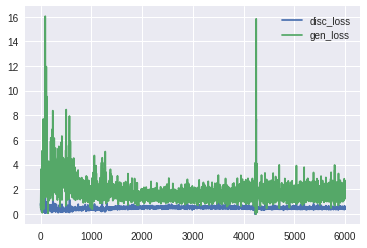

In [0]:
df['disc_loss'].plot()
df['gen_loss'].plot()
plt.legend()